In [1]:
# Import các thư viện cần thiết

import torch # type: ignore
import numpy as np # type: ignore
import torch.nn as nn # type: ignore
import torch.optim as optim # type: ignore
import matplotlib.pyplot as plt # type: ignore
import torch.nn.functional as F # type: ignore

from tqdm import tqdm # type: ignore
from torchsummary import summary # type: ignore
from torchvision import transforms, datasets # type: ignore
from torch.utils.data import DataLoader, random_split # type: ignore

In [2]:
# Xác định thiết bị tính toán

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
# Khai báo siêu tham số và tải dữ liệu

#Hyperparameters
batch_size = 256
img_size = 28    #original image size is 28x28
channels = 1     #grayscale image
latent_dim = 2
num_epochs = 50 #training epochs 500

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

In [12]:
# Chia dữ liệu và tạo DataLoader

# Split dataset into training (80%) and validation (20%)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Training samples: 48000, Validation samples: 12000


In [13]:
# Định nghĩa mô hình VAE

# Define the Variational Autoencoder (VAE) in PyTorch
class VAE(nn.Module):
    def __init__(self, channels, latent_dim):
        super(VAE, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(channels, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)

        self.flatten_dim = 64 * 7 * 7
        self.fc_mu = nn.Linear(self.flatten_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_dim, latent_dim)

        # Decoder
        self.fc_decode = nn.Linear(latent_dim, self.flatten_dim)
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding
        =1)
        self.deconv2 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding
        =1)
        self.conv_final = nn.Conv2d(16, channels, kernel_size=3, padding=1)

    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, self.flatten_dim)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = F.relu(self.fc_decode(z))
        x = x.view(-1, 64, 7, 7)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = torch.sigmoid(self.conv_final(x))
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

In [14]:
# Hàm mất mát của VAE

def loss_function(recon_x, x, mu, log_var, B=1000):
    # Flatten tensors for MSE calculation
    recon_x_flat = recon_x.view(recon_x.size(0), -1)
    x_flat = x.view(x.size(0), -1)

    # Calculate MSE (per element average)
    mse_out = F.mse_loss(recon_x_flat, x_flat, reduction='mean')

    # Scale by input dimensions
    reconstruction_loss = mse_out * x.shape[1] * x.shape[2] * x.shape[3]

    # Calculate KL divergence
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), axis=1)

    # Compute final loss (adding B*recon_loss + kl_loss)
    total_loss = B * reconstruction_loss + torch.mean(kl_loss)

    return total_loss, reconstruction_loss, torch.mean(kl_loss)

In [15]:
# Khởi tạo mô hình và bộ tối ưu

# Create model, optimizer, etc.
model = VAE(channels, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [16]:
# Huấn luyện mô hình và ghi log

import os
from datetime import datetime

# Create a log directory if it doesn't exist
log_dir = "logs"
os.makedirs(log_dir, exist_ok=True)

# Create a log file with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
log_file = os.path.join(log_dir, f"training_log_{timestamp}.txt")

# Open the log file
with open(log_file, "w") as f:
    f.write(f"Training started at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Model: VAE with latent_dim={latent_dim}\n")
    f.write(f"Batch size: {batch_size}, Image size: {img_size}x{img_size}\n")
    f.write(f"Total epochs: {num_epochs}\n\n")
    f.write("Epoch,Avg_Loss,Recon_Loss,KL_Loss\n")

# Training loop with logging
model.train()
for epoch in range(num_epochs):
    train_loss = 0.0
    epoch_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for data, _ in epoch_bar:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss, recon_loss, kl_loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        epoch_bar.set_postfix(loss=loss.item())

    # Calculate average loss
    avg_loss = train_loss / len(train_loader.dataset)

    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs} Loss per sample: {avg_loss:.4f} "
    f"Recon Loss: {recon_loss.item():.4f} KL Loss: {kl_loss.item():.4f}")

    # Save to log file
    with open(log_file, "a") as f:
        f.write(f"{epoch+1},{avg_loss:.6f},{recon_loss.item():.6f},{kl_loss.item():.6f}\n")

    # Log training completion
    with open(log_file, "a") as f:
        f.write(f"\nTraining completed at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

    print(f"Training log saved to {log_file}")

Epoch 1/50 Loss per sample: 365.7186 Recon Loss: 93.6963 KL Loss: 14.5611
Training log saved to logs/training_log_20250324_133928.txt


Epoch 2/50 Loss per sample: 221.6963 Recon Loss: 46.2691 KL Loss: 12.7049
Training log saved to logs/training_log_20250324_133928.txt


Epoch 3/50 Loss per sample: 166.9104 Recon Loss: 40.4301 KL Loss: 14.9413
Training log saved to logs/training_log_20250324_133928.txt


Epoch 4/50 Loss per sample: 154.0526 Recon Loss: 40.0501 KL Loss: 14.2772
Training log saved to logs/training_log_20250324_133928.txt


Epoch 5/50 Loss per sample: 146.9860 Recon Loss: 36.4762 KL Loss: 15.1111
Training log saved to logs/training_log_20250324_133928.txt


Epoch 6/50 Loss per sample: 143.0253 Recon Loss: 35.5352 KL Loss: 15.8329
Training log saved to logs/training_log_20250324_133928.txt


Epoch 7/50 Loss per sample: 140.3178 Recon Loss: 32.7786 KL Loss: 15.9630
Training log saved to logs/training_log_20250324_133928.txt


Epoch 8/50 Loss per sample: 138.4301 Recon Loss: 34.8180 KL Loss: 16.4035
Training log saved to logs/training_log_20250324_133928.txt


Epoch 9/50 Loss per sample: 136.7662 Recon Loss: 34.1649 KL Loss: 15.7156
Training log saved to logs/training_log_20250324_133928.txt


Epoch 10/50 Loss per sample: 135.3652 Recon Loss: 33.6322 KL Loss: 16.0399
Training log saved to logs/training_log_20250324_133928.txt


Epoch 11/50 Loss per sample: 134.4855 Recon Loss: 33.5873 KL Loss: 15.9035
Training log saved to logs/training_log_20250324_133928.txt


Epoch 12/50 Loss per sample: 133.5758 Recon Loss: 32.8497 KL Loss: 16.9414
Training log saved to logs/training_log_20250324_133928.txt


Epoch 13/50 Loss per sample: 132.8816 Recon Loss: 35.6493 KL Loss: 15.1381
Training log saved to logs/training_log_20250324_133928.txt


Epoch 14/50 Loss per sample: 132.1764 Recon Loss: 35.7518 KL Loss: 15.6341
Training log saved to logs/training_log_20250324_133928.txt


Epoch 15/50 Loss per sample: 131.4707 Recon Loss: 35.5439 KL Loss: 14.3277
Training log saved to logs/training_log_20250324_133928.txt


Epoch 16/50 Loss per sample: 130.8840 Recon Loss: 34.7432 KL Loss: 15.9866
Training log saved to logs/training_log_20250324_133928.txt


Epoch 17/50 Loss per sample: 130.3300 Recon Loss: 35.7078 KL Loss: 15.8616
Training log saved to logs/training_log_20250324_133928.txt


Epoch 18/50 Loss per sample: 129.9750 Recon Loss: 32.6634 KL Loss: 17.4567
Training log saved to logs/training_log_20250324_133928.txt


Epoch 19/50 Loss per sample: 129.3503 Recon Loss: 35.3411 KL Loss: 17.0724
Training log saved to logs/training_log_20250324_133928.txt


Epoch 20/50 Loss per sample: 129.0404 Recon Loss: 33.1284 KL Loss: 15.9924
Training log saved to logs/training_log_20250324_133928.txt


Epoch 21/50 Loss per sample: 128.3911 Recon Loss: 33.3776 KL Loss: 16.1314
Training log saved to logs/training_log_20250324_133928.txt


Epoch 22/50 Loss per sample: 128.2764 Recon Loss: 35.6306 KL Loss: 15.4679
Training log saved to logs/training_log_20250324_133928.txt


Epoch 23/50 Loss per sample: 127.9576 Recon Loss: 31.0534 KL Loss: 16.7934
Training log saved to logs/training_log_20250324_133928.txt


Epoch 24/50 Loss per sample: 127.6306 Recon Loss: 32.7569 KL Loss: 16.5417
Training log saved to logs/training_log_20250324_133928.txt


Epoch 25/50 Loss per sample: 127.2824 Recon Loss: 32.1901 KL Loss: 16.6899
Training log saved to logs/training_log_20250324_133928.txt


Epoch 26/50 Loss per sample: 126.9405 Recon Loss: 33.7139 KL Loss: 15.3368
Training log saved to logs/training_log_20250324_133928.txt


Epoch 27/50 Loss per sample: 126.5034 Recon Loss: 32.4213 KL Loss: 16.4713
Training log saved to logs/training_log_20250324_133928.txt


Epoch 28/50 Loss per sample: 126.2899 Recon Loss: 32.6916 KL Loss: 17.6907
Training log saved to logs/training_log_20250324_133928.txt


Epoch 29/50 Loss per sample: 126.0553 Recon Loss: 33.0470 KL Loss: 16.3716
Training log saved to logs/training_log_20250324_133928.txt


Epoch 30/50 Loss per sample: 125.8774 Recon Loss: 29.9110 KL Loss: 16.1897
Training log saved to logs/training_log_20250324_133928.txt


Epoch 31/50 Loss per sample: 125.7177 Recon Loss: 34.3073 KL Loss: 14.7701
Training log saved to logs/training_log_20250324_133928.txt


Epoch 32/50 Loss per sample: 125.3996 Recon Loss: 31.9836 KL Loss: 15.8388
Training log saved to logs/training_log_20250324_133928.txt


Epoch 33/50 Loss per sample: 125.3487 Recon Loss: 32.7873 KL Loss: 15.3434
Training log saved to logs/training_log_20250324_133928.txt


Epoch 34/50 Loss per sample: 125.0155 Recon Loss: 32.4522 KL Loss: 15.7234
Training log saved to logs/training_log_20250324_133928.txt


Epoch 35/50 Loss per sample: 124.9389 Recon Loss: 32.2357 KL Loss: 15.0145
Training log saved to logs/training_log_20250324_133928.txt


Epoch 36/50 Loss per sample: 124.6964 Recon Loss: 31.3042 KL Loss: 15.6691
Training log saved to logs/training_log_20250324_133928.txt


Epoch 37/50 Loss per sample: 124.3636 Recon Loss: 33.0922 KL Loss: 15.4454
Training log saved to logs/training_log_20250324_133928.txt


Epoch 38/50 Loss per sample: 124.3057 Recon Loss: 32.4040 KL Loss: 15.7481
Training log saved to logs/training_log_20250324_133928.txt


Epoch 39/50 Loss per sample: 123.9074 Recon Loss: 31.4005 KL Loss: 17.2315
Training log saved to logs/training_log_20250324_133928.txt


Epoch 40/50 Loss per sample: 123.8195 Recon Loss: 33.7527 KL Loss: 14.8681
Training log saved to logs/training_log_20250324_133928.txt


Epoch 41/50 Loss per sample: 123.7049 Recon Loss: 31.9443 KL Loss: 15.5623
Training log saved to logs/training_log_20250324_133928.txt


Epoch 42/50 Loss per sample: 123.6206 Recon Loss: 33.7426 KL Loss: 15.9014
Training log saved to logs/training_log_20250324_133928.txt


Epoch 43/50 Loss per sample: 123.5227 Recon Loss: 29.8900 KL Loss: 16.3773
Training log saved to logs/training_log_20250324_133928.txt


Epoch 44/50 Loss per sample: 123.2111 Recon Loss: 30.9241 KL Loss: 16.0776
Training log saved to logs/training_log_20250324_133928.txt


Epoch 45/50 Loss per sample: 123.1663 Recon Loss: 33.1062 KL Loss: 15.1925
Training log saved to logs/training_log_20250324_133928.txt


Epoch 46/50 Loss per sample: 122.8209 Recon Loss: 30.2614 KL Loss: 15.8956
Training log saved to logs/training_log_20250324_133928.txt


Epoch 47/50 Loss per sample: 122.5884 Recon Loss: 28.9387 KL Loss: 15.9657
Training log saved to logs/training_log_20250324_133928.txt


Epoch 48/50 Loss per sample: 122.4939 Recon Loss: 32.8737 KL Loss: 17.2579
Training log saved to logs/training_log_20250324_133928.txt


Epoch 49/50 Loss per sample: 122.5657 Recon Loss: 32.3966 KL Loss: 14.9974
Training log saved to logs/training_log_20250324_133928.txt


Epoch 50/50 Loss per sample: 122.2844 Recon Loss: 30.7425 KL Loss: 15.3275
Training log saved to logs/training_log_20250324_133928.txt


In [17]:
# Kiểm tra và trực quan hóa ảnh tái tạo

# After training, visualize the reconstruction on validation images
model.eval()
with torch.no_grad():
    data_iter = iter(val_loader)
    images, _ = next(data_iter)
    images = images.to(device)
    recon_images, _, _ = model(images)

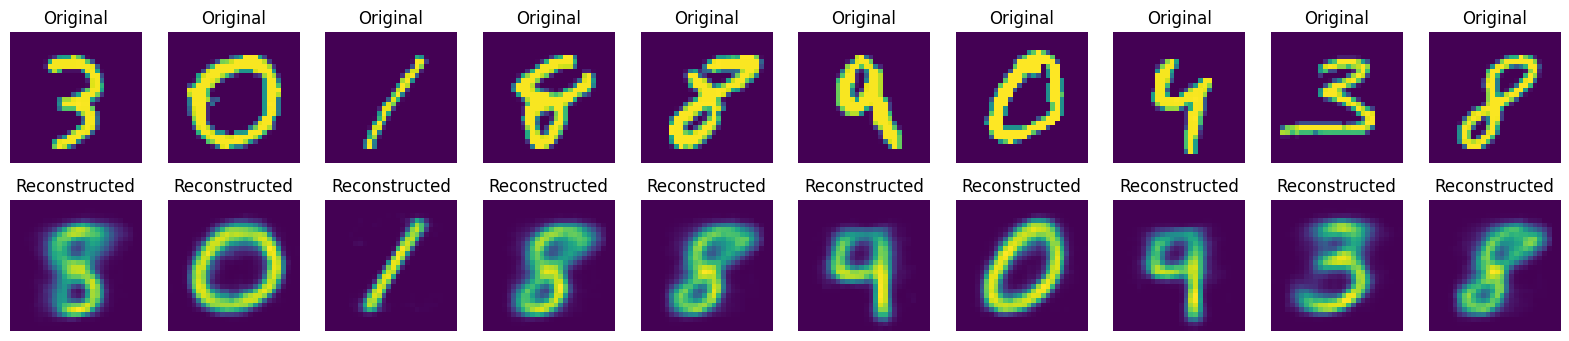

In [18]:
# Trực quan hóa ảnh gốc và ảnh tái tạo

# Plot original and reconstructed images side by side
n = 10 # number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
# Original image: (C,H,W) -> (H,W,C)
    orig = images[i].cpu().permute(1, 2, 0).numpy()
    recon = recon_images[i].cpu().permute(1, 2, 0).numpy()

    ax = plt.subplot(2, n, i + 1)
    plt.imshow(orig)
    plt.title("Original")
    plt.axis('off')

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon)
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()